<a href="https://colab.research.google.com/github/nicolasvazquez95/Aprendiendo_DeepLearning/blob/main/06_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Mini 🍔👀


In [ ]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np

# Helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 
import helper_functions as helper

--2022-01-25 23:08:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-25 23:08:55 (87.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Get 10% of all data (101 classes)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
helper.unzip_data('101_food_classes_10_percent.zip')

# Set directories
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

# Load data 
train_10p = keras.preprocessing.image_dataset_from_directory(train_dir,label_mode='categorical',
                                                             image_size=(224,224),seed=42)
test_10p = keras.preprocessing.image_dataset_from_directory(test_dir,label_mode='categorical',
                                                            image_size=(224,224),seed=42,
                                                            shuffle=False)

--2022-01-25 23:08:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 142.251.107.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   179MB/s    in 8.7s    

2022-01-25 23:09:04 (178 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# First model, transfer learning

## ModelCheckpoint Callback
ckpt_filepath = "checkpoints/model_1/model_1-e{epoch:02d}.ckpt"
ckpt_callback = keras.callbacks.ModelCheckpoint(ckpt_filepath,verbose=1,save_weights_only=True,monitor='val_accuracy',
                                                save_best_only=True)

## Data Augmentation Layer
data_augmentation = keras.models.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
  keras.layers.experimental.preprocessing.RandomRotation(0.2),
  keras.layers.experimental.preprocessing.RandomZoom(0.2),
  keras.layers.experimental.preprocessing.RandomWidth(0.2),
  keras.layers.experimental.preprocessing.RandomHeight(0.2)],
  name='data_augmentation'
  )

## Headless EfficientNetB0 model
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

## Model
inputs = keras.layers.Input(shape=(224,224,3),name='input_layer')
x = data_augmentation(inputs)
x = base_model(x,training=False)
x = keras.layers.GlobalAveragePooling2D(name='AvgPooling_layer')(x)
outputs = keras.layers.Dense(101,activation='softmax',name='output_layer')(x)
model = keras.Model(inputs,outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
history_10p = model.fit(train_10p,epochs=5,
                    steps_per_epoch = len(train_10p),
                    validation_data=test_10p,validation_steps=int(0.15*len(test_10p)),
                    callbacks=[helper.create_tensorboard_callback('Food101','model0_10percent_data'),
                               ckpt_callback])

Saving TensorBoard log files to: Food101/model0_10percent_data/20220125-143918
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


237/237 [==============================] - ETA: 0s - loss: 3.4660 - accuracy: 0.2578
Epoch 00001: val_accuracy improved from -inf to 0.37579, saving model to checkpoints/model_1/model_1-e01.ckpt
237/237 [==============================] - 133s 490ms/step - loss: 3.4660 - accuracy: 0.2578 - val_loss: 2.7654 - val_accuracy: 0.3758
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.3372 - accuracy: 0.4587
Epoch 00002: val_accuracy improved from 0.37579 to 0.44862, saving model to checkpoints/model_1/model_1-e02.ckpt
237/237 [==============================] - 97s 408ms/step - loss: 2.3372 - accuracy: 0.4587 - val_loss: 2.2957 - val_accuracy: 0.4486
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.9694 - accuracy: 0.5312
Epoch 00003: val_accuracy improved from 0.44862 to 0.47669, saving model to checkpoints/model_1/model_1-e03.ckpt
237/237 [==============================] - 83s 347ms/step - loss: 1.9694 - accuracy: 0.5312 - val_loss: 2.1104 - val_acc

In [ ]:
model.evaluate(test_10p)

790/790 [==============================] - 101s 128ms/step - loss: 1.7174 - accuracy: 0.5536


[1.717384934425354, 0.5536237359046936]

In [ ]:
# Fine-tuning the model

## Unfreeze the last 5 layers 
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

## Recompile
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
history_10p = model.fit(train_10p,epochs=10,
                    steps_per_epoch = len(train_10p),
                    validation_data=test_10p,validation_steps=int(0.15*len(test_10p)),
                    callbacks=[helper.create_tensorboard_callback('Food101','model0_10percent_data'),
                               ckpt_callback],
                        initial_epoch=5)

Saving TensorBoard log files to: Food101/model0_10percent_data/20220125-152038
Epoch 6/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


237/237 [==============================] - ETA: 0s - loss: 1.3568 - accuracy: 0.6488
Epoch 00006: val_accuracy improved from 0.49258 to 0.49629, saving model to checkpoints/model_1/model_1-e06.ckpt
237/237 [==============================] - 91s 347ms/step - loss: 1.3568 - accuracy: 0.6488 - val_loss: 1.9613 - val_accuracy: 0.4963
Epoch 7/10
237/237 [==============================] - ETA: 0s - loss: 1.2251 - accuracy: 0.6752
Epoch 00007: val_accuracy improved from 0.49629 to 0.50450, saving model to checkpoints/model_1/model_1-e07.ckpt
237/237 [==============================] - 79s 330ms/step - loss: 1.2251 - accuracy: 0.6752 - val_loss: 1.9481 - val_accuracy: 0.5045
Epoch 8/10
237/237 [==============================] - ETA: 0s - loss: 1.1639 - accuracy: 0.6956
Epoch 00008: val_accuracy did not improve from 0.50450
237/237 [==============================] - 74s 308ms/step - loss: 1.1639 - accuracy: 0.6956 - val_loss: 1.9790 - val_accuracy: 0.4955
Epoch 9/10
237/237 [====================

In [ ]:
model.evaluate(test_10p)

790/790 [==============================] - 101s 128ms/step - loss: 1.6226 - accuracy: 0.5732


[1.622648000717163, 0.5732277035713196]

In [ ]:
## Load the checkpoint epoch10
### Mount drive
#from google.colab import drive
#drive.mount('/content/drive')

model.load_weights('drive/MyDrive/Food101_ckpt/model_1-e10.ckpt')
#model.evaluate(test_10p) # Loads OK!

In [ ]:
# Predictions
pred_proba = model.predict(test_10p,verbose=1)
## Predicted classes (argmax)
pred_classes = pred_proba.argmax(axis=1)

790/790 [==============================] - 78s 86ms/step


In [ ]:
# Get test labels
y_labels = []
for images,labels in test_10p.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
# Make a confusion matrix
helper.make_confusion_matrix(y_labels,pred_classes,
                             classes=test_10p.class_names,
                             figsize=(100,100),text_size=20)

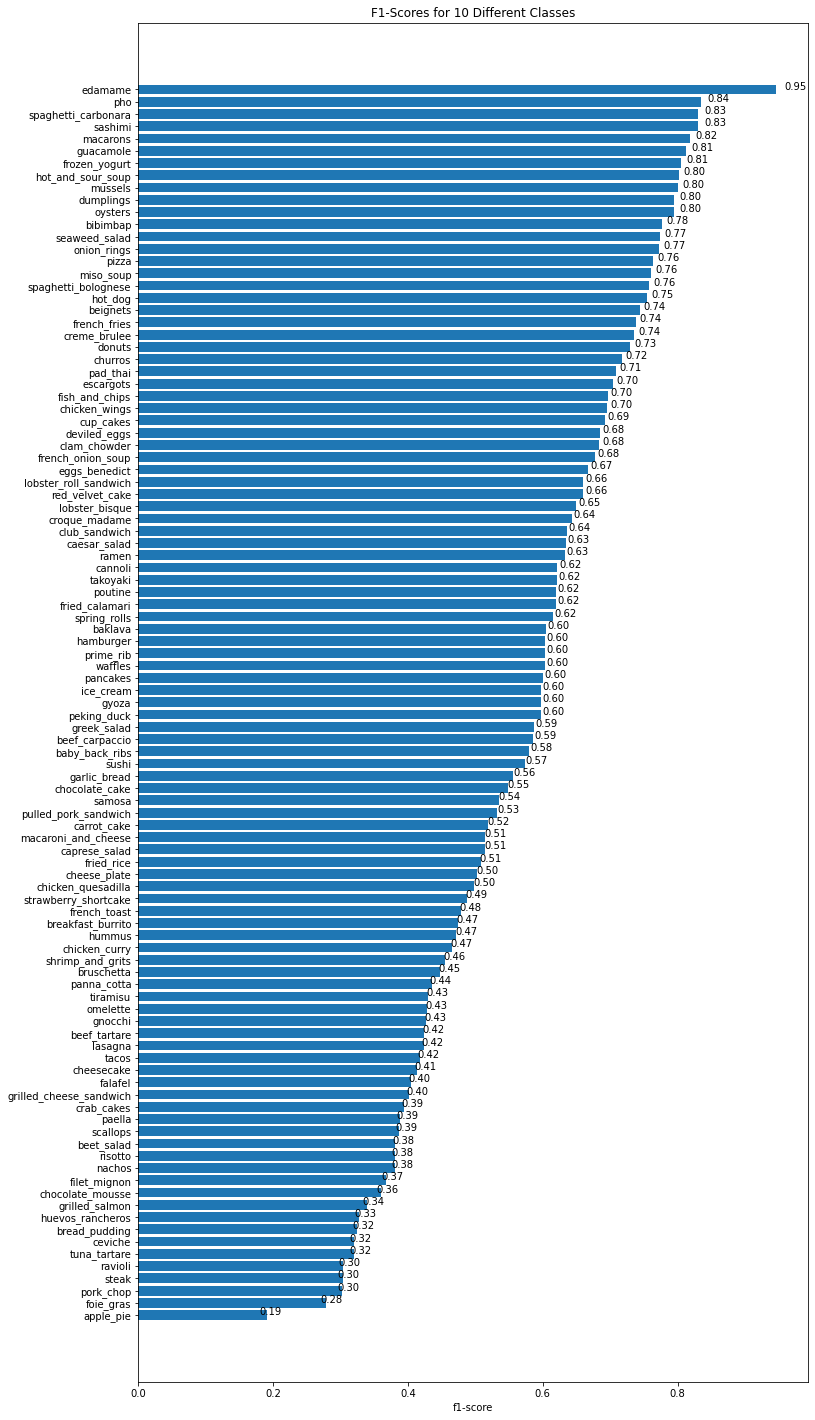

In [ ]:
# Plot of F1-score for all classes
import pandas as pd
from sklearn.metrics import classification_report

classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[train_10p.class_names[int(k)]] = v["f1-score"]
# Turn f1-scores into dataframe for visualization
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

# Figure
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 101 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

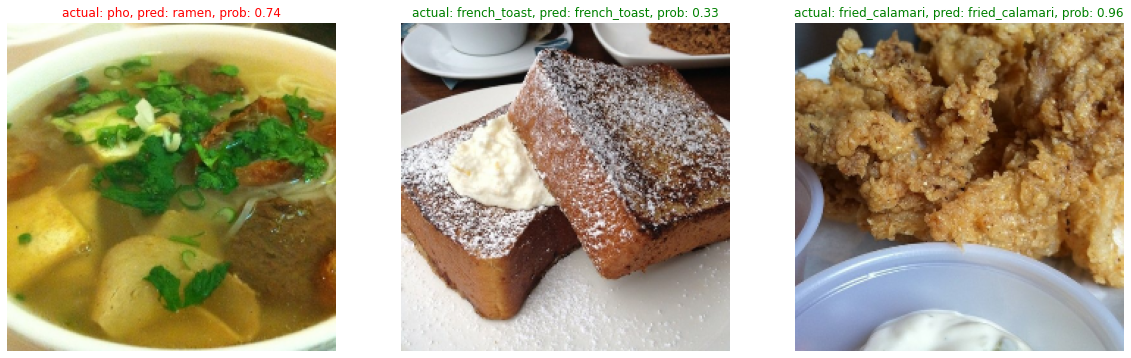

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(test_10p.class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = test_10p.class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

